# September 15, 2022: FC matrices: MAX trial level responses: Mashid ROIs: 
<!-- Statistical analysis using graph theoretic measures -->

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform
from brainiak.fcma.util import compute_correlation

# network analyses
import networkx as nx

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

set_name = 'mashid'

args.SEED = 74
np.random.seed(args.SEED)

# ROIs
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"
args.roi_set_df = pd.read_csv(roi_set_file)
args.roi_set_df = args.roi_set_df.sort_values(by=['network'])
# display(args.roi_set_df)

args.roi_names = args.roi_set_df['roi_name'].values
args.nw_names = args.roi_set_df['network'].values
args.roi_idxs = args.roi_set_df.index.values
args.num_rois = len(args.roi_idxs)

# trial level responses
with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'rb') as f:
    X = pickle.load(f)

# change roi ordering
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

In [3]:
'''
plotting tick labels
'''
ticks = []
for nw in np.unique(args.nw_names):
    ticks.append(np.where(args.nw_names == nw)[0].shape[0])
args.ticks = np.array(ticks)
print(args.ticks)

minor_ticks = np.cumsum(args.ticks)
args.major_ticks = minor_ticks - args.ticks // 2
args.minor_ticks = minor_ticks[:-1]
print(args.minor_ticks)
print(args.major_ticks)

args.major_tick_labels = np.unique(args.nw_names)
print(args.major_tick_labels)

[12 13  8 12]
[12 25 33]
[ 6 19 29 39]
['Executive' 'Salience' 'Subcortical' 'Task negative']


In [5]:
ts = fc_utils.get_max_block_time_series(args, X)

minimum number of trials = 11


## FC

In [6]:
args.n_bootstraps = 1000
corrs, bootstraps, rois = fc_utils.get_fcs(args, ts, print_stats=True)

condition safe_early: 65.75757575757575 %significant roi(-pairs)
condition safe_late: 62.22222222222222 %significant roi(-pairs)
condition threat_early: 72.92929292929293 %significant roi(-pairs)
condition threat_late: 69.5959595959596 %significant roi(-pairs)


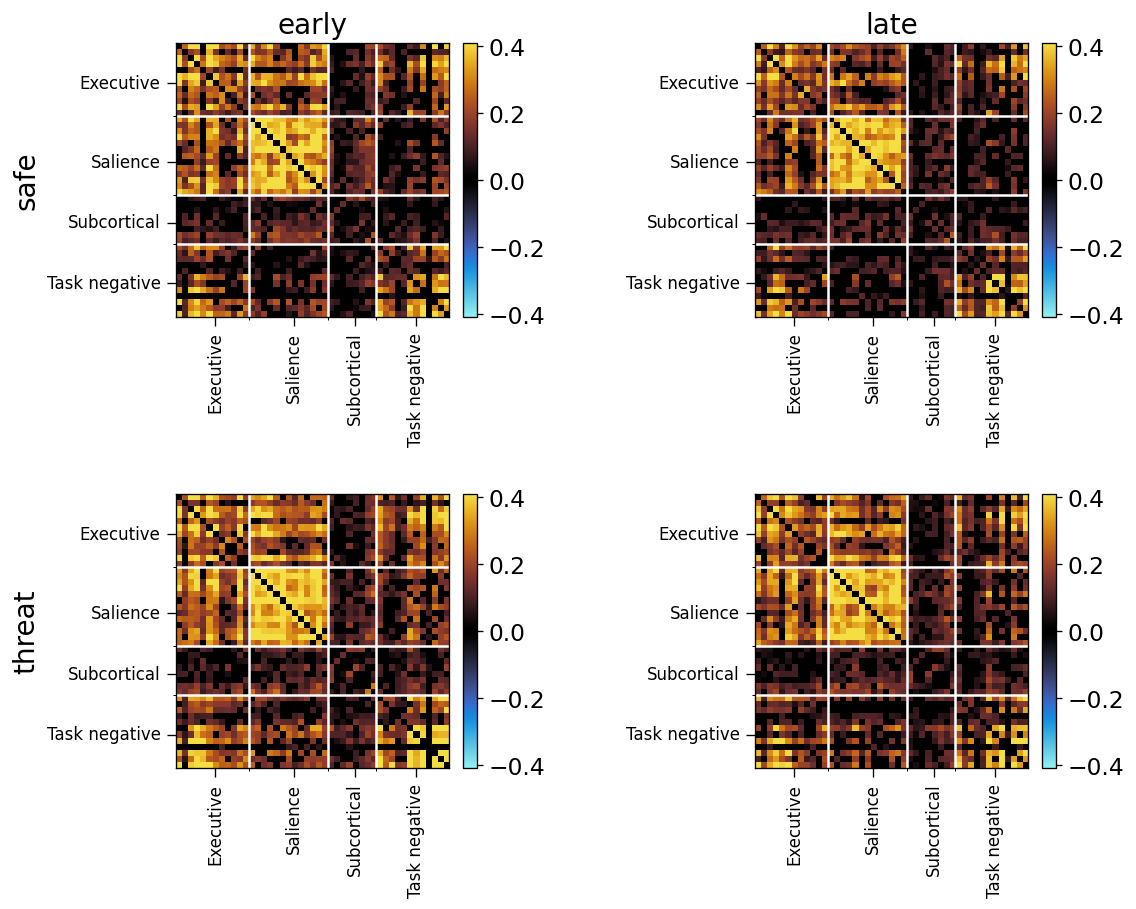

In [7]:
(
    observed_fcs, observed_p_vals, 
    significant_rois, conf_intervals
) = fc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=True
)

fc_utils.plot_max_fcs(args, observed_fcs, significant_rois)

In [8]:
args.n_resamples = 1000
comp_results = fc_utils.get_fc_comparison_stats(args, corrs, paradigm='max')
diff_fcs, diff_pvals = fc_utils.get_diff_fcs(args, comp_results, threshold_mats=True)

6it [00:11,  1.87s/it]


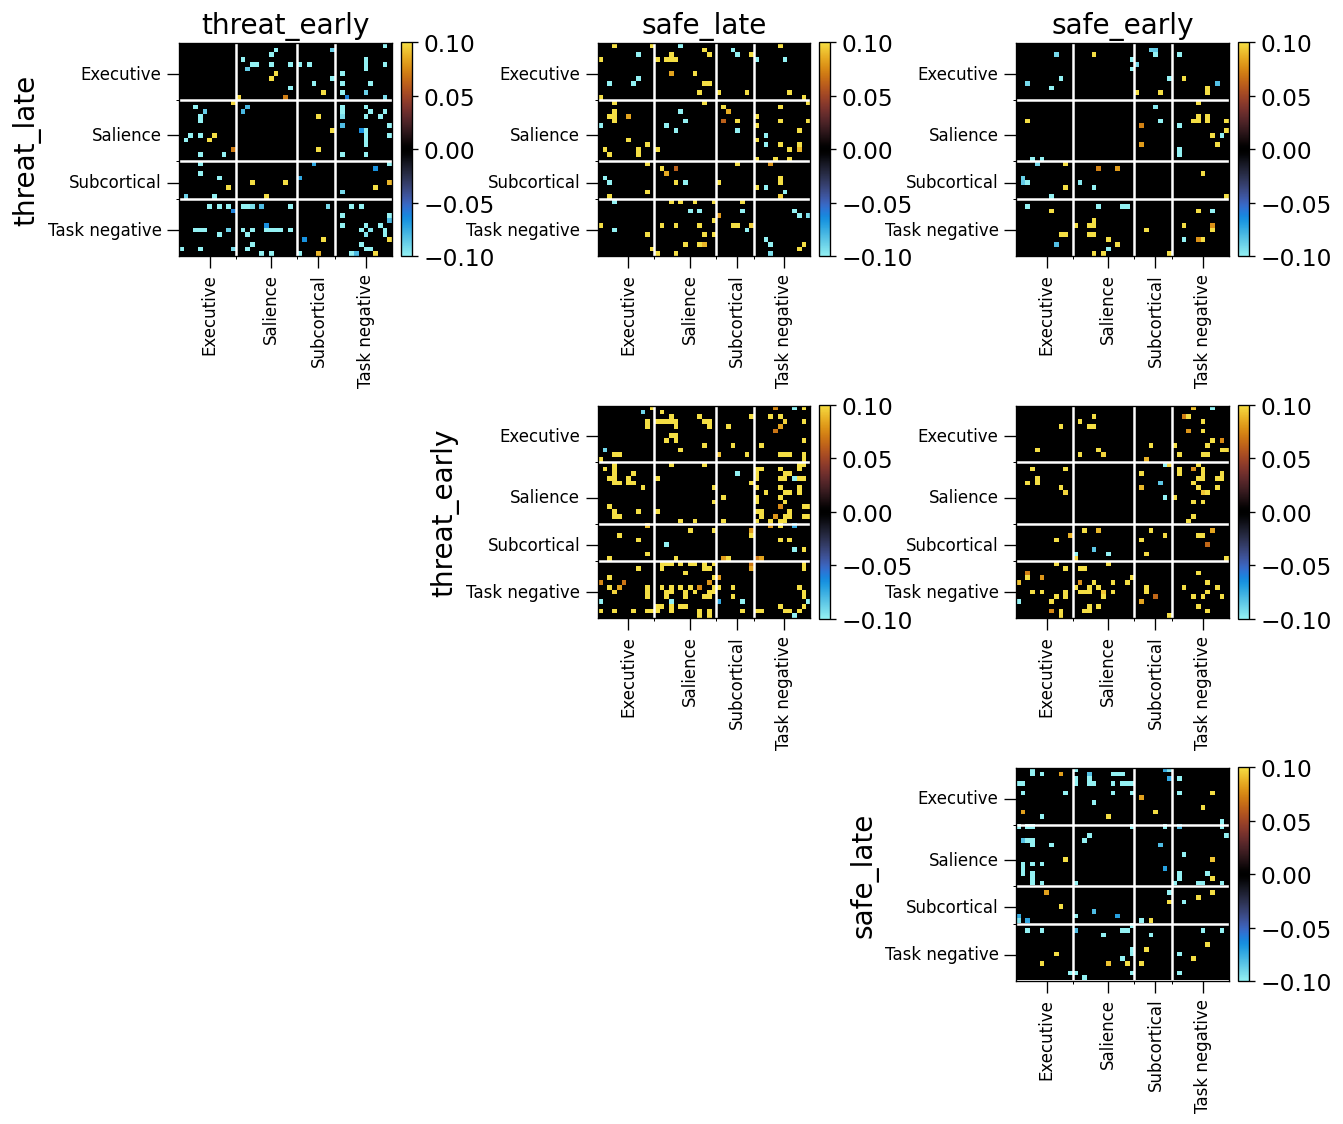

In [9]:
fc_utils.plot_max_fc_comparisons(args, corrs, diff_fcs)